In [1]:
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split    
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from RSData import *
from HaiYangData import *
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sea_ice_model import * 
from sklearn import svm
import graphviz
import pandas as pd
import numpy as np
import glob,os
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches




In [2]:
grid_path1 = r'E:\python_workfile\sea_ice_classification\training7\output\VV_HH_polarratio\pridect\grid'
grid_path2 = r'E:\python_workfile\sea_ice_classification\training6\dt_output\split_VV_HH\VV\WEEK\grid'
grid_path3 = r'E:\python_workfile\sea_ice_classification\training6\dt_output\split_VV_HH\VV\DOY+dynamic_threshold\grid'

In [3]:
files_list=[]

In [4]:
files_list1=glob.glob(grid_path1+'\\*.npy')
files_list2=glob.glob(grid_path2+'\\*.npy')
files_list3=glob.glob(grid_path3+'\\*.npy')

In [5]:
pridect_1 = [(np.load(file)) for file in files_list1]
pridect_2 = [(np.load(file)) for file in files_list2]
pridect_3 = [(np.load(file)) for file in files_list3]

In [6]:
lat_grid = np.load(r'E:\python_workfile\sea_ice_classification\training7\dataset\lat.npy')
lon_grid = np.load(r'E:\python_workfile\sea_ice_classification\training7\dataset\lon.npy')


In [7]:
pridect_grids_1 = [(np.load(file)).flatten() for file in files_list1]
pridect_grids_2 = [(np.load(file)).flatten() for file in files_list2]
pridect_grids_3 = [(np.load(file)).flatten() for file in files_list3]

In [8]:
satellite = r'AARI'
sensor = r'AARI'
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=30000)
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

x_map, y_map = hy_sca.get_map_grid(transformer_back)

In [9]:
def vote(x):
    typea, typeb, typec = x['model1'],x['model2'],x['model3']
    count_d = {0:0,1:0,2:0,3:0,4:0,5:0} 
    if typea+ typeb+ typec==0:
        return 0
    count_d[typea]+=1
    count_d[typeb]+=1
    count_d[typec]+=1
    if (sorted(count_d.items(),key=lambda x:x[1])[-1][0]!=0):
        return sorted(count_d.items(),key=lambda x:x[1])[-1][0]
    else:
        return sorted(count_d.items(),key=lambda x:x[1])[-2][0]
    

In [10]:
'''
获取文件名称
'''
val_dir = r'E:\python_workfile\sea_ice_classification\training6\csv\add_threshold\val'
val_files = glob.glob(val_dir + '\\*.csv')
val_day = [val_file.split('\\')[-1].split('.')[0] for val_file in val_files]


In [11]:
true_grid_files =glob.glob(r'E:\python_workfile\sea_ice_classification\training7\dataset\val_grid' + '\\*.npy')

In [20]:
FI = mpatches.Patch(color='maroon', label='Fast Ice')
OI = mpatches.Patch(color='orange', label='Old Ice')
FYI = mpatches.Patch(color='lime', label='First Year Ice')
YI = mpatches.Patch(color='dodgerblue', label='Young Ice')
N = mpatches.Patch(color='midnightblue', label='Nilas')

# 动态阈值画图用
FYI_dynamic = mpatches.Patch(color='maroon', label='First Year Ice')
MYI_dynamic = mpatches.Patch(color='midnightblue', label='Multi-Year Ice')

# 做海冰分类差画图用(2类)
FYI_C_MYI = mpatches.Patch(color='midnightblue', label='Ture: FYI \n Predict: MYI')
MYI_C_FYI = mpatches.Patch(color='maroon', label='Ture: MYI \n Predict: FYI')

# 设置字体
font = {
    'size':18
}

In [14]:
save_dir = r'E:\python_workfile\sea_ice_classification\training7\output\ensemble'
classes = ['nials', 'young ice', 'first year ice', 'old ice', 'fast ice']


In [15]:
true_grid_files

['E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20191029.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20191223.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20200123.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20200223.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20200322.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20200422.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20200522.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20201023.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20201123.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\20201215.npy',
 'E:\\python_workfile\\sea_ice_classification\\training7\\dataset\\val_grid\\202

In [21]:
for  i,(pridect_grid_1,pridect_grid_2, pridect_grid_3,day) in enumerate(zip(pridect_grids_1[:],pridect_grids_2[:],pridect_grids_3[:],val_day[:])):
    ture_grid = np.load(true_grid_files[i])
    data = pd.DataFrame(columns=['model1','model2','model3'])
    data['model1']=pridect_grid_1
    data['model2']=pridect_grid_2
    data['model3']=pridect_grid_3
    data.fillna(0, inplace = True)
    data['output'] =  data.apply(vote,axis=1)
    
    output_ar = np.array(data['output'])
    output_ar = output_ar.reshape(1333,1333).astype(np.float)
    output_ar[output_ar==0]=np.nan
    
#     # 绘制预测值
#     fig = plt.figure(figsize=(9, 9))
#     fig.add_subplot(111)
#     fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

#     hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
#     hy_m.pcolor(x_map, y_map, data=output_ar, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)

#     hy_m.fillcontinents()
#     hy_m.drawmapboundary()
#     hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
#     hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
#     plt.title('Ensemble Mask '+str(day))
#     plt.legend(loc='upper right',handles=[FI,OI ,FYI, YI ,N], title='Ice Type')
#     plt.savefig(save_dir+'\\ '+str(day)+'.png')
#     plt.close()
    
    
#     output_ar_fl = output_ar.flatten()
#     ture_grid_fl = ture_grid.flatten()

#     # 去除nan点
#     true_nan_mask = np.where(np.isnan(ture_grid_fl)==True)
#     output_ar_fl = np.delete(output_ar_fl,true_nan_mask)
#     ture_grid_fl = np.delete(ture_grid_fl,true_nan_mask)
#     out_nan_mask = np.where(np.isnan(output_ar_fl)==True)
#     output_ar_fl = np.delete(output_ar_fl,out_nan_mask)
#     ture_grid_fl = np.delete(ture_grid_fl,out_nan_mask)
#     cm = confusion_matrix(ture_grid_fl, output_ar_fl)
#     if cm.shape[0]<5:
#         pad_value = 5-cm.shape[0]
#         cm = np.pad(cm, (0,pad_value), 'constant')
#     plot_confusion_matrix(classes,cm, save_dir + '\\'+str(day)+'confusion_matrix_decisition tree.png', title='confusion matrix precision:{0} '.format(precision_score(ture_grid_fl, output_ar_fl, average='weighted')))
    
    # 绘制真值与预测值（融合）的差
    ture_grid[ture_grid <=3] = 1
    ture_grid[ture_grid >3] = 2
    output_ar[output_ar <=3] = 1
    output_ar[output_ar >3] = 2
    
    diff_grid = ture_grid - output_ar
    diff_grid[diff_grid == 0] = np.nan
    
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1,vmin=-1,latlon = True)
    hy_m.fillcontinents()
    hy_m.drawmapboundary()
    hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
    plt.title('Diff mask '+str(day) + '  True mask - Predict Mask')
    plt.legend(loc='upper right',handles=[FYI_C_MYI,MYI_C_FYI ], title='Ice Type Diff', prop=font)
    plt.savefig(save_dir+'\\Diff '+str(day)+'.png')
    plt.close()
    
    print(day) 

C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20191029


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20191223


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20200123


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20200223


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20200322


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20200422


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20200522


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20201023


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20201123


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20201215


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20210122


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20210319


C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:49: RuntimeWarning: invalid value encountered in less_equal
  ture_grid[ture_grid <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:50: RuntimeWarning: invalid value encountered in greater
  ture_grid[ture_grid >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:51: RuntimeWarning: invalid value encountered in less_equal
  output_ar[output_ar <=3] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:52: RuntimeWarning: invalid value encountered in greater
  output_ar[output_ar >3] = 2
C:\Users\user\AppData\Local\Temp/ipykernel_21960/4124702427.py:61: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=diff_grid, cmap=plt.cm.jet,shading = 'auto',vmax=1

20210406


In [121]:
ture_grid = np.load(true_grid_files[0])

In [122]:
# 一天一天的处理
data = pd.DataFrame(columns=['model1','model2','model3'])

In [123]:
data['model1']=pridect_grids_1[0]
data['model2']=pridect_grids_2[0]
data['model3']=pridect_grids_3[0]

In [124]:
data['lat'] = y_map.flatten()
data['lon'] = x_map.flatten()


In [125]:
data.fillna(0, inplace = True)

In [126]:
data['output'] =  data.apply(vote,axis=1)

In [127]:
output_ar = np.array(data['output'])
output_ar = output_ar.reshape(1333,1333).astype(np.float)
output_ar[output_ar==0]=np.nan

C:\Users\user\AppData\Local\Temp/ipykernel_25260/3243501235.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=output_ar, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)


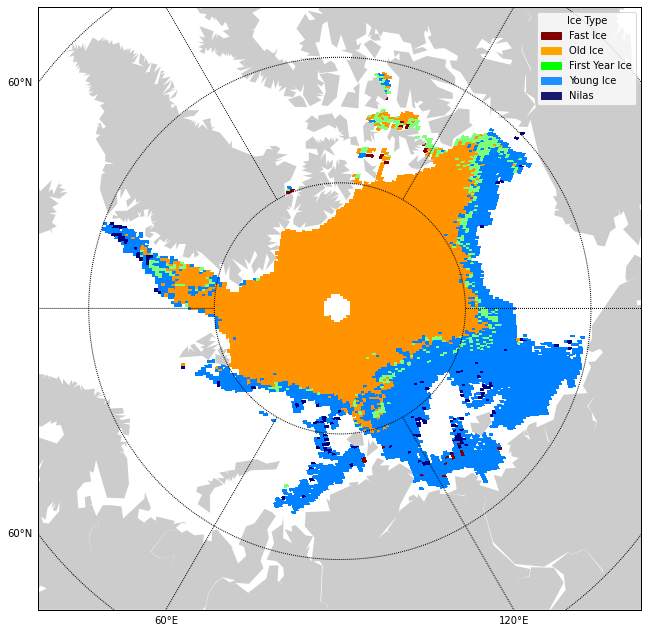

In [128]:
    
    # 绘制预测值
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolor(x_map, y_map, data=output_ar, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)

    hy_m.fillcontinents()
    hy_m.drawmapboundary()
    hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
#     plt.show()
    plt.legend(loc='upper right',handles=[FI,OI ,FYI, YI ,N], title='Ice Type')


C:\Users\user\AppData\Local\Temp/ipykernel_25260/3159221511.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=ture_grid, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)


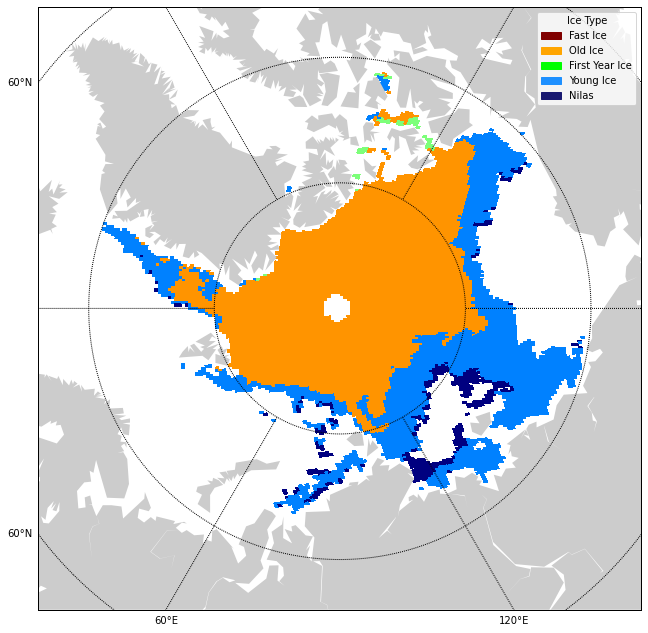

In [129]:
    # 绘制预测值
    fig = plt.figure(figsize=(9, 9))
    fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolor(x_map, y_map, data=ture_grid, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)

    hy_m.fillcontinents()
    hy_m.drawmapboundary()
    hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
#     plt.show()
    plt.legend(loc='upper right',handles=[FI,OI ,FYI, YI ,N], title='Ice Type')


In [58]:
output_ar = np.array(data['output'])

output_ar = output_ar.reshape(1333,1333).astype(np.float)

output_ar[output_ar==0]=np.nan

In [28]:
data.head()

,model1,model2,model3,output
0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0


In [149]:
output_ar_fl = output_ar.flatten()

ture_grid_fl = ture_grid.flatten()


In [150]:

# 去除nan点
true_nan_mask = np.where(np.isnan(ture_grid_fl)==True)

output_ar_fl = np.delete(output_ar_fl,true_nan_mask)
ture_grid_fl = np.delete(ture_grid_fl,true_nan_mask)

out_nan_mask = np.where(np.isnan(output_ar_fl)==True)

output_ar_fl = np.delete(output_ar_fl,out_nan_mask)
ture_grid_fl = np.delete(ture_grid_fl,out_nan_mask)

# # nan点
# output_ar_fl = np.nan_to_num(output_ar_fl)
# ture_grid_fl = np.nan_to_num(ture_grid_fl)

In [131]:
output_ar_fl = np.nan_to_num(output_ar_fl)
ture_grid_fl = np.nan_to_num(ture_grid_fl)

In [151]:
cm = confusion_matrix(ture_grid_fl, output_ar_fl)

In [152]:
cm

array([[  37,  379,    3,    0,    5],
       [  35, 3001,  321,  186,    6],
       [   0,    2,   36,   10,    1],
       [   0,  178,   91, 5587,    0],
       [   0,    0,    0,    0,    0]], dtype=int64)

In [135]:
cm[1:,1:]

array([[  37,  379,    3,    0,    5],
       [  35, 3001,  321,  186,    6],
       [   0,    2,   36,   10,    1],
       [   0,  178,   91, 5587,    0],
       [   0,    0,    0,    0,    0]], dtype=int64)

In [153]:
precision_score(ture_grid_fl, output_ar_fl, average='weighted')

0.8980616821135848

In [140]:
a=np.sum(cm[1:,1:])

In [141]:
b=np.sum(np.diagonal(cm[1:,1:], offset=0, axis1=0, axis2=1))

In [145]:
b-a

-1217

In [144]:
np.diagonal(cm[1:,1:], offset=0, axis1=0, axis2=1)

array([  37, 3001,   36, 5587,    0], dtype=int64)

In [77]:


value_array = np.empty(shape=(data.shape[0],5))


value_array[:,0] = data['lat']
value_array[:,1] = data['lon']
value_array[:,2],value_array[:,3] = transformer.transform(value_array[:,0], value_array[:,1])
value_array[:,4] = data['model2']


13519
14114
grid_array = np.zeros((hy_sca.nlat, hy_sca.nlon))





x = (value_array[:,2] / hy_sca.resolution).astype(np.int16)
y = (value_array[:,3] / hy_sca.resolution).astype(np.int16)


grid_array[y,x] += value_array[:,4]



C:\Users\user\AppData\Local\Temp/ipykernel_12880/3824342201.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  hy_m.pcolor(x_map, y_map, data=ourput_ar, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)


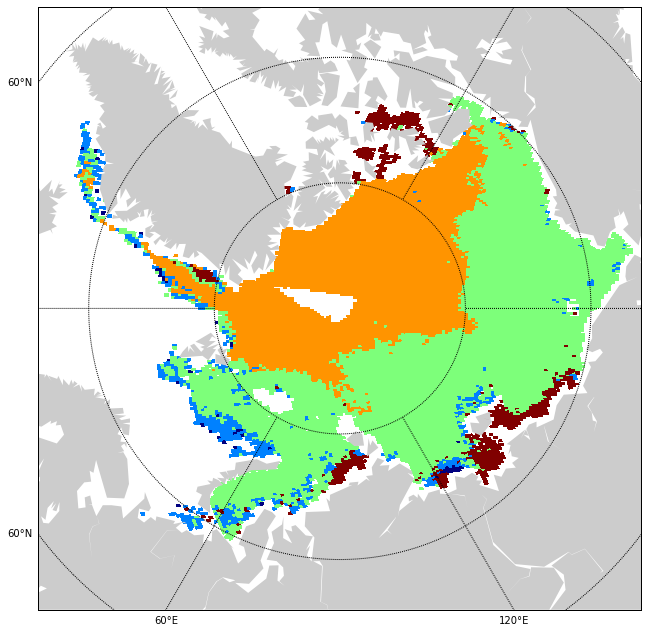

In [83]:


grid_array[grid_array == 0] = np.nan
    # 绘制预测值
fig = plt.figure(figsize=(9, 9))
fig.add_subplot(111)
fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
hy_m.pcolor(x_map, y_map, data=ourput_ar, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)

hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.show()
# plt.title('Predict mask '+str(day))
# plt.legend(loc='upper right',handles=[FI,OI ,FYI, YI ,N], title='Ice Type')
# plt.savefig(predict_save_dir+'\\predict '+str(day)+'.png')
# plt.close()